### Import the necessary packages

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
import fractions

### Import train and test dataset

In [6]:
train=pd.read_csv("../input/usa-property-dataset/dataset/train.csv")
test=pd.read_csv("../input/usa-property-dataset/dataset/test.csv")

### Pre-processing function

In [8]:
def pre_process(df):
    
    #change column names to lowercase
    df=df.rename(columns={col:col.lower()   for col in df.columns.values})

    #replace the unkwoun categeory levels
    df['property_type']= df['property_type'].replace("#R%$G&867",np.nan)

    """creating a missing value indicator for column """
    def miss_indicator(df):
        for col in df.columns[df.isnull().any()].values:
            df[col+'_is_null']=(df[col].isnull()).astype('int') 
        return df

    df=miss_indicator(df)
    
    """trim and tidy the categorical column values"""
    def tidy_row_value(df):
        def check(x):
            if x is np.nan:
                return x
            else:
                return re.sub("\s|-","_",x.lower())  

        for i in ['property_type', 'furnishing', 'power_backup','water_supply', 'crime_rate', 'dust_and_noise']:
            df[i]=df[i].apply(lambda x:check(x))
        return df      

    df=tidy_row_value(df)
    
    # fill missing for the column property_type
    
    df['property_type']=df['property_type'].fillna(df.groupby(['number_of_doors'])['property_type'].transform(pd.Series.mode))
    df['property_type']=df['property_type'].fillna(df['property_type'].mode()[0])
    
    #fill missing for the column number_of_windows
    
    df['number_of_windows']=df['number_of_windows'].fillna(df.groupby(['property_type'])['number_of_windows'].transform('median'))  
    df['number_of_windows']=df['number_of_windows'].fillna(df['number_of_windows'].median())
  
    #fill missing for the column furnishing
    
    df['furnishing']=df['furnishing'].fillna(df['furnishing'].mode()[0])     
    
    #fill missing for the column frequency_of_powercuts

    df['frequency_of_powercuts']=df['frequency_of_powercuts'].fillna(df.groupby(['property_type'])['frequency_of_powercuts'].transform('median'))
    df['frequency_of_powercuts']=df['frequency_of_powercuts'].fillna(df['frequency_of_powercuts'].mode()[0])

    #fill missing for the column crime_rate
    
    df['crime_rate']=df['crime_rate'].fillna(df['crime_rate'].mode()[0])

    #fill missing for the column dust_and_noise

    df['dust_and_noise']=df['dust_and_noise'].fillna(df['dust_and_noise'].mode()[0])



    """door and windows ratio"""
    def door_window_ratio(door,window):
        gcd=fractions.gcd(14,6)
        door_ratio=door/gcd
        window_ratio=window/gcd
        return f"{door_ratio}:{window_ratio}"
    
    df['doors_windows_ratio']=df.apply(lambda x:door_window_ratio(x.number_of_doors,x.number_of_windows),axis=1)
    
    
    """change air_quality_index values to category"""
    def air_quality_index_category(x):
        if x in range(0,50):
            return 'good'
        elif x in range(51,100):
            return 'moderate'
        elif x in range(101,150):
            return 'unhealthy_for_sensitive_groups'
        elif x in range(151,200):
            return 'unhealthy'
        elif x in range(201,300):
            return 'very_unhealthy'
        else:
            return 'hazardous'
       
    
    df['air_quality_index_category']=df['air_quality_index'].apply(lambda x:air_quality_index_category(x))
    
 
   
    """categorical columns list"""
    grpcol=[#'property_type',
            #'furnishing',
     #'frequency_of_powercuts',
     # 'power_backup',
      #  'water_supply', 
        
      #  'crime_rate',
       # 'dust_and_noise',
        'air_quality_index_category',
        
      ]

    """numerical columns list"""
    numcols=['property_area','number_of_windows','number_of_doors',
       'traffic_density_score','air_quality_index','neighborhood_review' ]


    """group by numerical summary of each numerical column"""
    def feature_eng(df):
        for valcol in numcols:
            df1=(df.groupby(grpcol)[valcol].
             agg({'min','median','mean','max'}).reset_index())
            df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|mean|max)")]}))
            df=pd.merge(df,df1,on=grpcol,how='left')
        return df  


    df=feature_eng(df)

    """z-score outlier detection for numerical columns"""   
    def outlier_z(df,x):
        threshold = 3
        out=[]
        mean = np.mean(df[x])
        std = np.std(df[x])
        for i in df[x]:
            if ((i-mean)/std) > threshold:
                out.append(1)
            else:
                out.append(0)
        return out
    
    for col in ['property_area', 'traffic_density_score',
            'air_quality_index','neighborhood_review' ]:
        df[f"{col}_outlier"]= outlier_z(df,col)
    
    
    
   
    return df

### Apply the pre-process steps to train dataset

In [9]:
train=pre_process(train)

### Import pycaret regresion model

In [2]:
!pip install imbalanced-learn==0.7.0
!pip install --user pycaret[full] -q
!pip install numba==0.53 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hypertools 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stumpy 1.11.1 requires numba>=0.54, but you have numba 0.53.0 which is incompatible.
hypertools 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
cudf 21.10.1 requires numba>=0.53.1, but you have numba 0.53.0 which is incompatible.


In [3]:
import pycaret

In [4]:
from pycaret.regression import *

In [20]:
for i,j in enumerate(train.columns.values):
    print(f"{i}_{j}")  

0_property_id
1_property_type
2_property_area
3_number_of_windows
4_number_of_doors
5_furnishing
6_frequency_of_powercuts
7_power_backup
8_water_supply
9_traffic_density_score
10_crime_rate
11_dust_and_noise
12_air_quality_index
13_neighborhood_review
14_habitability_score
15_property_type_is_null
16_number_of_windows_is_null
17_furnishing_is_null
18_frequency_of_powercuts_is_null
19_crime_rate_is_null
20_dust_and_noise_is_null
21_doors_windows_ratio
22_air_quality_index_category
23_property_area_mean
24_property_area_median
25_property_area_min
26_property_area_max
27_number_of_windows_mean
28_number_of_windows_median
29_number_of_windows_min
30_number_of_windows_max
31_number_of_doors_mean
32_number_of_doors_median
33_number_of_doors_min
34_number_of_doors_max
35_traffic_density_score_mean
36_traffic_density_score_median
37_traffic_density_score_min
38_traffic_density_score_max
39_air_quality_index_mean
40_air_quality_index_median
41_air_quality_index_min
42_air_quality_index_max
43_

### Create predictors and response column.

In [11]:
X=train.iloc[:,np.r_[1:14,15:51]]
y=train['habitability_score']

### Create a new dataframe with selected predictor and response column

In [12]:
train1=pd.concat([X,y],axis=1)


### Setup the data for model

In [113]:
reg_pycaret = setup(data = train1,
                    data_split_shuffle=True,
                    fold_strategy="kfold",
                    fold_shuffle=True,
                    fold=5,
                    target = 'habitability_score', session_id=112,
                    use_gpu =True,
                    silent=True
                    
                    ) 
set_config('seed', 123)

,Description,Value
0,session_id,112
1,Target,habitability_score
2,Original Data,"(39499, 50)"
3,Missing Values,False
4,Numeric Features,23
5,Categorical Features,26
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(27649, 146)"


### Compare multiple regression models and evalute by using R2.

In [16]:
top3 = compare_models(sort = 'R2',n_select=3) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4.6017,35.8650,5.9880,0.8210,0.0955,0.0698,5.6140
lightgbm,Light Gradient Boosting Machine,4.8186,37.5961,6.1305,0.8124,0.0962,0.0725,0.7300
catboost,CatBoost Regressor,4.7916,37.5905,6.1305,0.8124,0.0975,0.0725,7.3900
xgboost,Extreme Gradient Boosting,4.8870,39.3572,6.2729,0.8036,0.0994,0.0737,0.8160
et,Extra Trees Regressor,4.8310,40.3693,6.3532,0.7985,0.1004,0.0731,29.5400
gbr,Gradient Boosting Regressor,5.6450,49.7036,7.0492,0.7520,0.1121,0.0858,6.7500
dt,Decision Tree Regressor,6.0773,67.5450,8.2176,0.6629,0.1302,0.0917,0.5040
ada,AdaBoost Regressor,6.7574,71.3201,8.4434,0.6442,0.1425,0.1070,4.7220
br,Bayesian Ridge,7.2505,81.5571,9.0303,0.5931,0.1560,0.1182,0.4820
omp,Orthogonal Matching Pursuit,7.2705,82.0004,9.0547,0.5909,0.1564,0.1186,0.0780


### Blend the top 3 models.

In [17]:
blender = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5825,34.7022,5.8909,0.8328,0.0929,0.0693
1,4.6335,34.6926,5.8900,0.8263,0.0937,0.0700
2,4.5748,34.3972,5.8649,0.8219,0.0916,0.0685
3,4.6570,35.2455,5.9368,0.8256,0.0927,0.0703
4,4.7575,37.7093,6.1408,0.8112,0.0980,0.0721
Mean,4.6410,35.3493,5.9447,0.8236,0.0938,0.0700
Std,0.0659,1.2114,0.1008,0.0071,0.0022,0.0012


### Finalize the blender model

In [21]:
final = finalize_model(blender)

In [22]:
from sklearn import set_config
set_config(display="diagram")

In [23]:
final

VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('lightgbm',
                             LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0, device='gpu',
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=112,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent='warn', subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7f3ff7c8b6d0>)],
                n_jobs=1, verbose=False, weights=None)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [135]:
rf_mod=RandomForestRegressor()

In [136]:
rfr = create_model(rf_mod)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.5429,35.6394,5.9699,0.8283,0.0944,0.0688
1,4.6451,35.7088,5.9757,0.8212,0.0960,0.0705
2,4.5469,35.2206,5.9347,0.8177,0.0941,0.0685
3,4.6451,36.5435,6.0451,0.8192,0.0950,0.0704
4,4.6879,37.9234,6.1582,0.8102,0.0987,0.0713
Mean,4.6136,36.2071,6.0167,0.8193,0.0956,0.0699
Std,0.0582,0.9594,0.0793,0.0058,0.0017,0.0011


### Model Residual Plot

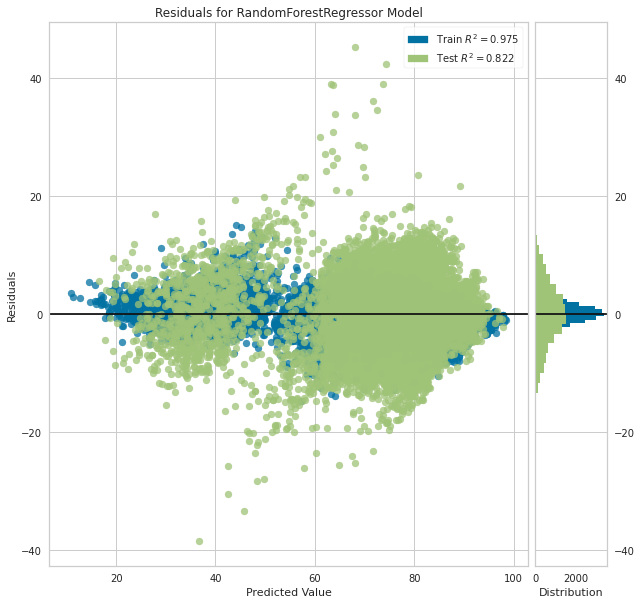

In [138]:
plt.figure(figsize = (10,10))
plot_model(rfr, plot = 'residuals')

### Error plot

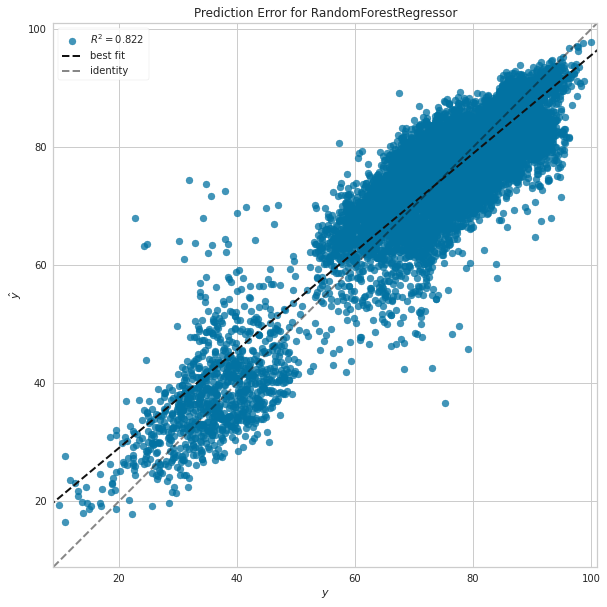

In [139]:
plt.figure(figsize = (10,10))
plot_model(rfr, plot = 'error')

### Randomforest model feature importance plot

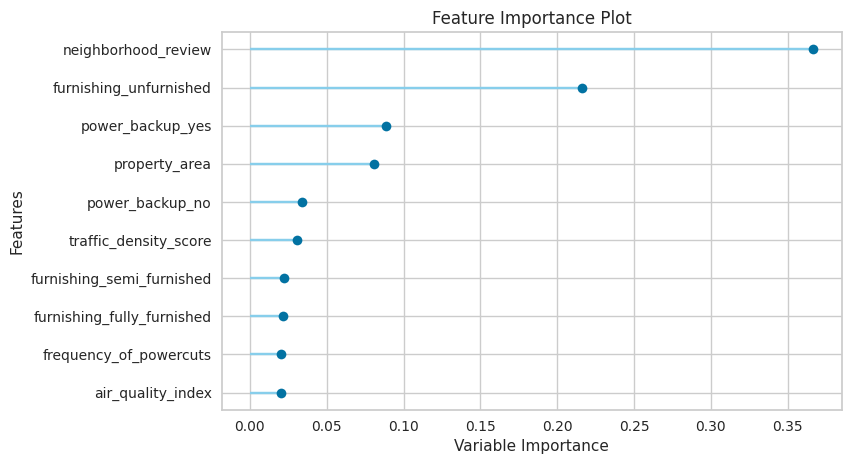

In [140]:
plot_model(rfr, plot='feature')

### Apply the pre-process steps tom test data

In [113]:
test=pre_process(test)

### Predict the test data

In [124]:
test['Habitability_score']=(predict_model(final, data=test.loc[:,X.columns])['Label'])

### Create result dataframe

In [125]:
res=pd.DataFrame({'Property_ID':test['property_id'],'Habitability_score':test['Habitability_score']})

### Write the dataframe to csv

In [127]:
res.to_csv("pycaret_blend_final.csv",index=False)